In [13]:
import sys
import math
import numpy as np
import ceo
import IPython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 401
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
src    = ceo.Source("J",zenith=0.,azimuth=0.,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
#src    = ceo.Source("J",zenith=np.array([6,6])*ceo.constants.ARCMIN2RAD,
#                    azimuth=np.array([0,90])*math.pi/180,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt = ceo.GMT_MX(D,nPx)
#wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

### Initialize and Calibrate Dispersed Fringe Sensor (DFS)

In [3]:
sps = ceo.DispersedFringeSensor(gmt.M1,src)#,nyquist_factor=2)
sps.INIT_ALL_ATTRIBUTES = True
sps.calibrate(src,gmt)

#### Display all fftlet images and overplot the following:
1) Blue circles: Blob detection (three per fftlet image)
2) Line passing through the three blobs
3) Line perpendicular to the above line, passing between the central and upper-most lobe. 

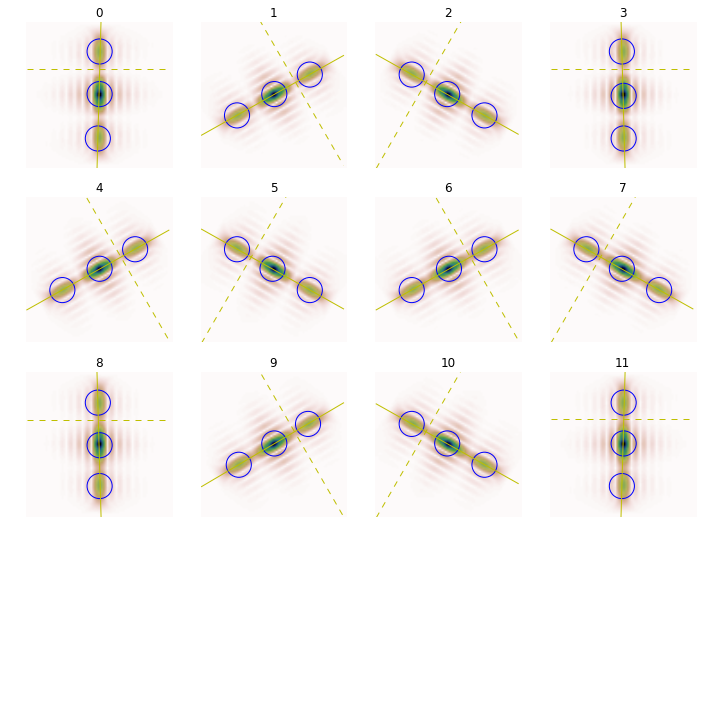

In [5]:
dataCube = sps.get_data_cube(data_type='fftlet')

fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((12,12))
xvec = np.arange(0,sps.camera.N_PX_IMAGE,10)
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=cm.gist_earth_r, origin='lower')
    (ax.ravel())[k].autoscale(False)
    (ax.ravel())[k].plot(xvec, xvec*sps.pl_m[k] + sps.pl_b[k], 'y')
    (ax.ravel())[k].plot(xvec, xvec*sps.pp_m[k] + sps.pp_b[k], 'y--')
    for pp in range(3):
        c1 = Circle((sps.blob_data[k,pp,1], sps.blob_data[k,pp,0]),radius=np.sqrt(2)*sps.blob_data[k,pp,2], 
                    color='b', fill=False)    
        (ax.ravel())[k].add_patch(c1)
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

#### Show the calibrated masks
The masks leave only the upper-most lobe, a.k.a. the detection lobe, visible.

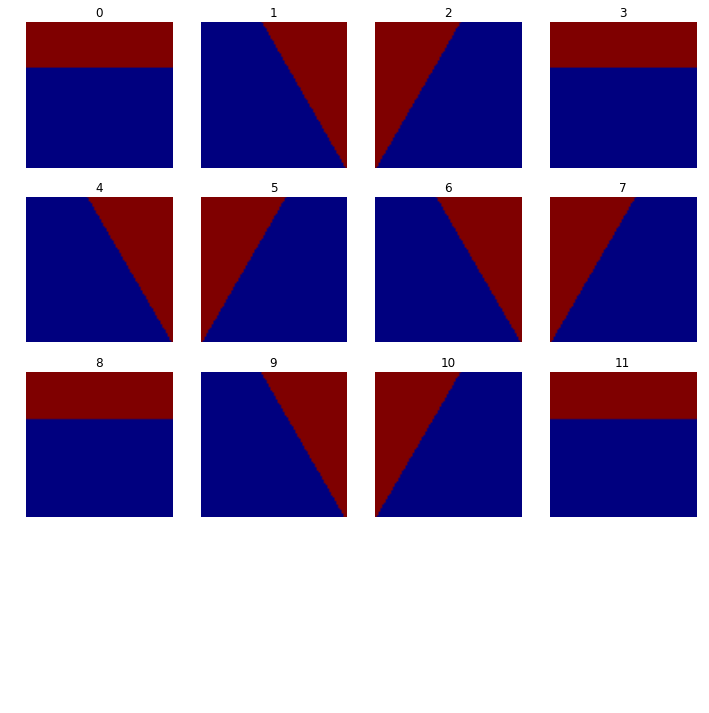

In [5]:
fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((12,12))
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(sps.spsmask[:,:,k], origin='lower')
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

### Compute the DFS reference position vector
The detection lobes are shown below, with the contour of the best-fit 2D Gaussian overplotted.

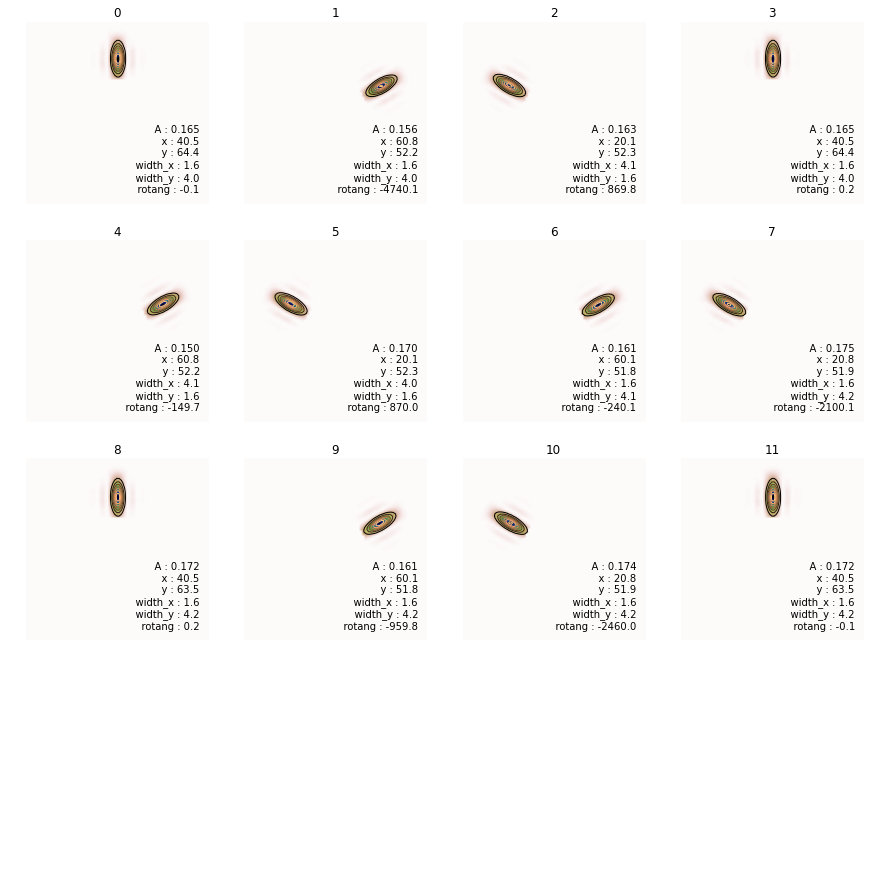

In [8]:
gmt.reset()
src.reset()
gmt.propagate(src)
sps.reset()
sps.analyze(src)
SPSmeas_ref = sps.measurement 

dataCube = sps.get_data_cube(data_type='fftlet')
fig, ax = subplots(sps.camera.N_SIDE_LENSLET,sps.camera.N_SIDE_LENSLET)
fig.set_size_inches((15,15))
for k in range(src.N_SRC*12):   
    (ax.ravel())[k].imshow(dataCube[:,:,k]*sps.spsmask[:,:,k], cmap=plt.cm.gist_earth_r, origin='lower')
    (ax.ravel())[k].contour(sps.fftlet_fit_images[:,:,k], cmap=plt.cm.copper, origin='lower')
    (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)
    params = sps.fftlet_fit_params[:,k]
    text(0.95, 0.05, """
    A : %.3f
    x : %.1f
    y : %.1f
    width_x : %.1f
    width_y : %.1f
    rotang : %.1f""" %(params[0], params[2], params[1], params[4], params[3], params[5]),
        fontsize=10, horizontalalignment='right',
        verticalalignment='bottom', transform=(ax.ravel())[k].transAxes)

for k in range(sps.camera.N_SIDE_LENSLET**2):
    (ax.ravel())[k].axis('off')

### Explore the capture range of the DFS
Piston a segment from 0 to 20 $\mu$m WF and record the DFS measurement (along with other Gaussian fit outputs).

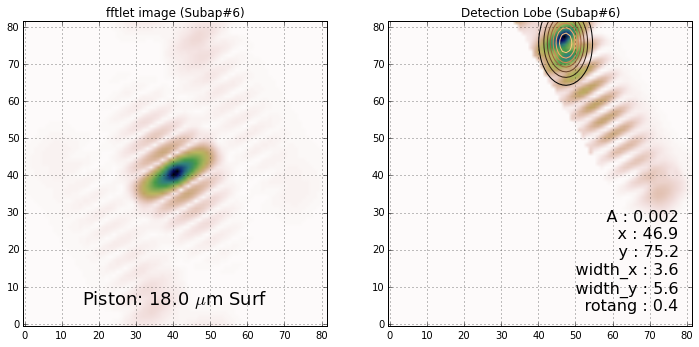

In [41]:
segId = 1 # segment number to scan in piston
subap = 6 # DFS subaperture to monitor visually

segStroke = np.arange(0,20,2, dtype=float)  #in microns
SPSmeas = np.zeros((12*src.N_SRC, segStroke.size))
lobeA = np.zeros((12*src.N_SRC, segStroke.size))
#lobex = np.zeros(segStroke.size)
#lobey = np.zeros(segStroke.size)
#lobewx = np.zeros(segStroke.size)
#lobewy = np.zeros(segStroke.size)

fig, (ax1,ax2) = subplots(1,2)
fig.set_size_inches((12,7))

for pp in range(segStroke.size):
    gmt.reset()
    gmt.M1.motion_CS.origin[segId-1,2] = segStroke[pp]*1e-6
    gmt.M1.motion_CS.update()
    src.reset()
    gmt.propagate(src)
    sps.reset()
    sps.analyze(src, lobe_detection='gaussfit')
    SPSmeas[:,pp] = sps.measurement - SPSmeas_ref
    lobeA[:,pp] = sps.fftlet_fit_params[0,:]
    #lobex[pp] = x
    #lobey[pp] = y
    #lobewx[pp] = width_x
    #lobewy[pp] = width_y   
    
    ### -> For visualization only:
    dataCube = sps.get_data_cube(data_type='fftlet')
    params = sps.fftlet_fit_params[:,subap]
    if pp > 0:
        mytext.remove()
        amptext.remove()
        for coll in mycontour.collections: coll.remove()
    ax1.imshow(np.sqrt(dataCube[:,:,subap]), cmap=plt.cm.gist_earth_r, origin='lower')
    ax2.imshow(dataCube[:,:,subap]*sps.spsmask[:,:,subap], cmap=plt.cm.gist_earth_r, origin='lower')
    mycontour = ax2.contour(sps.fftlet_fit_images[:,:,subap], cmap=plt.cm.copper, origin='lower')
    
    ax2.grid(True)
    ax2.set_title('Detection Lobe (Subap#%d)'%subap)
    ax1.grid(True)
    ax1.set_title('fftlet image (Subap#%d)'%subap)
    amptext = text(0.5,0.05, """Piston: %.1f $\mu$m Surf"""%segStroke[pp], fontsize=18, 
                   verticalalignment='bottom', horizontalalignment='center', transform=ax1.transAxes)
    mytext = text(0.95, 0.04, """
    A : %.3f
    x : %.1f
    y : %.1f
    width_x : %.1f
    width_y : %.1f
    rotang : %.1f""" %(params[0], params[2], params[1], params[4], params[3], params[5]),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax2.transAxes)
    IPython.display.clear_output(wait=True)
    IPython.display.display(fig)

close()

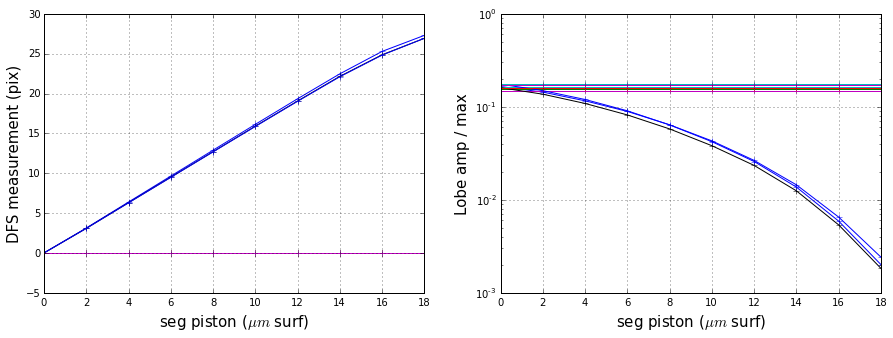

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((15,5))

ax1.plot(segStroke, SPSmeas.T, '-+')
ax1.set_xlabel('seg piston ($\mu m$ surf)', fontsize=15)
ax1.set_ylabel('DFS measurement (pix)', fontsize=15)
ax1.grid()

ax2.plot(segStroke, lobeA.T, '-+')
ax2.grid()
ax2.set_xlabel('seg piston ($\mu m$ surf)', fontsize=15)
ax2.set_ylabel('Lobe amp / max', fontsize=15)
ax2.set_yscale('log')